# Value regression

In [116]:
import seaborn as sns

df = sns.load_dataset("mpg").drop("name", axis=1)


<Axes: xlabel='origin'>

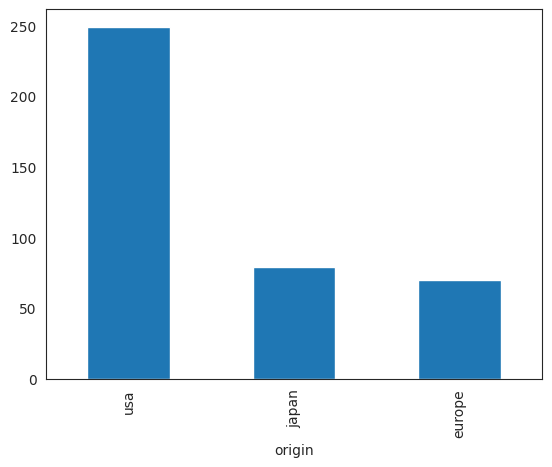

In [117]:
df["origin"].value_counts().plot(kind="bar")

In [118]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    392 non-null    float64
 4   weight        398 non-null    int64  
 5   acceleration  398 non-null    float64
 6   model_year    398 non-null    int64  
 7   origin        398 non-null    object 
dtypes: float64(4), int64(3), object(1)
memory usage: 25.0+ KB


In [119]:
df.query('horsepower.isna()')


,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin
32,25.0,4,98.0,NaN,2046,19.0,71,usa
126,21.0,6,200.0,NaN,2875,17.0,74,usa
330,40.9,4,85.0,NaN,1835,17.3,80,europe
336,23.6,4,140.0,NaN,2905,14.3,80,usa
354,34.5,4,100.0,NaN,2320,15.8,81,europe
374,23.0,4,151.0,NaN,3035,20.5,82,usa


In [120]:
df.dropna(inplace=True, axis=0)

<Axes: xlabel='model_year'>

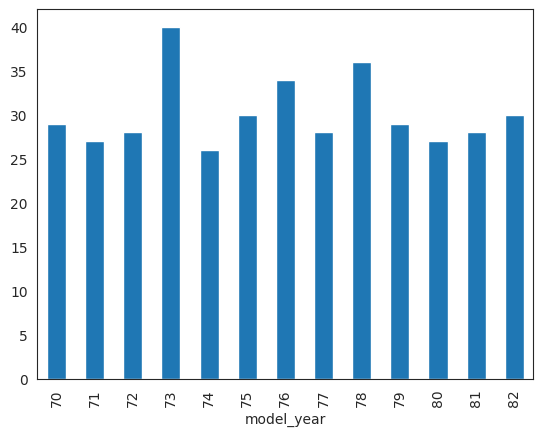

In [121]:
df["model_year"].value_counts().sort_index().plot(kind="bar")

In [122]:
import pandas as pd
bins = pd.IntervalIndex.from_tuples([(69,73), (74,77), (78, 82)])

df["model_year"] = pd.cut(df["model_year"], bins=bins)

df = pd.get_dummies(df, columns=["model_year", "origin"], drop_first=True)
df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,"model_year_(74, 77]","model_year_(78, 82]",origin_japan,origin_usa
0,18.0,8,307.0,130.0,3504,12.0,False,False,False,True
1,15.0,8,350.0,165.0,3693,11.5,False,False,False,True
2,18.0,8,318.0,150.0,3436,11.0,False,False,False,True
3,16.0,8,304.0,150.0,3433,12.0,False,False,False,True
4,17.0,8,302.0,140.0,3449,10.5,False,False,False,True


In [123]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X, y = df.drop("mpg", axis=1).values, df["mpg"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=42)

scaler = StandardScaler()

scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

X_train.shape, X_test.shape

((274, 9), (118, 9))

In [124]:
scaled_X_train.max()

np.float64(3.2869431314281545)

In [125]:
from sklearn.linear_model import LinearRegression

model_lr = LinearRegression()
model_lr.fit(scaled_X_train, y_train)

intercept, coef = model_lr.intercept_, model_lr.coef_
coef

array([-0.07963534,  0.71698622, -1.5802261 , -4.49219087, -0.08849455,
        0.36793355,  2.76523073,  0.02957218, -1.25074873])

In [126]:
import keras
from keras import layers
from keras.optimizers import SGD

inputs = keras.Input(shape=(X_train.shape[1],), name="Input layer")
outputs = layers.Dense(1, name="output_layer")(inputs)
model_shallow = keras.Model(inputs=inputs, outputs=outputs)

model_shallow.compile(loss="mean_squared_error", optimizer=SGD(learning_rate=.01))

model_shallow.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input layer (InputLayer)        │ (None, 9)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │            10 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10 (40.00 B)

 Trainable params: 10 (40.00 B)

 Non-trainable params: 0 (0.00 B)

In [127]:
model_shallow.fit(scaled_X_train, y_train, epochs=50, verbose=0,
                  validation_data=(scaled_X_test, y_test))

<Axes: xlabel='Epochs', ylabel='loss'>

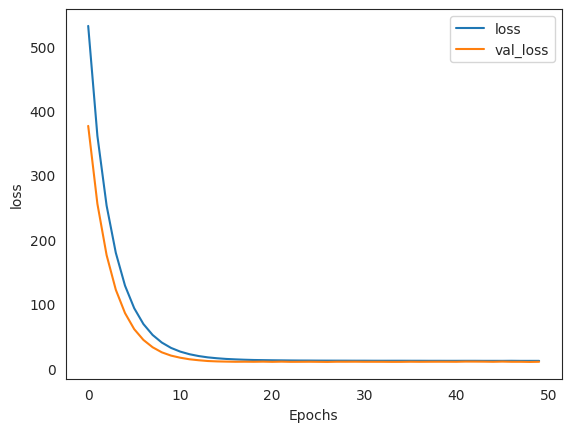

In [128]:
pd.DataFrame(model_shallow.history.history).plot(xlabel="Epochs", ylabel="loss")

In [129]:
weights, bias = model_shallow.layers[1].get_weights()
weights, coef

(array([[-0.6594189 ],
        [-0.34751594],
        [-1.7333069 ],
        [-2.9510498 ],
        [-0.35806343],
        [ 0.24135137],
        [ 2.6298923 ],
        [ 0.22889233],
        [-1.0009978 ]], dtype=float32),
 array([-0.07963534,  0.71698622, -1.5802261 , -4.49219087, -0.08849455,
         0.36793355,  2.76523073,  0.02957218, -1.25074873]))

In [130]:
bias, intercept

(array([23.62018], dtype=float32), np.float64(23.637591240875913))

In [131]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

def evaluate_regression(y_test, y_pred):
    mse = mean_squared_error(y_test, y_pred)
    return mean_absolute_error(y_test, y_pred), mse, np.sqrt(mse)

y_pred_NN = model_shallow.predict(scaled_X_test)
y_pred_lr = model_lr.predict(scaled_X_test)

scores = {model: evaluate_regression(y_test, y_pred) for model, y_pred in zip(["NN", "LR"], [y_pred_NN, y_pred_lr])}

df_scores = pd.DataFrame(scores, index=["MAE", "MSE", "RMSE"]).T

df_scores["RMSE_prop"] = df_scores["RMSE"] / y_test.mean()

df_scores

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


,MAE,MSE,RMSE,RMSE_prop
NN,2.518851,10.024691,3.166179,0.137655
LR,2.522334,9.742016,3.121220,0.135700


# Classification

In [132]:
from sklearn.datasets import load_breast_cancer
import seaborn as sns

sns.set_style("white")

raw_data = load_breast_cancer()
X, y = raw_data.data, raw_data.target

np.isnan(X).any()

np.False_

In [133]:
X.shape, y.shape

((569, 30), (569,))

In [134]:
scaler = StandardScaler()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_train_val, X_val, y_train_val, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=42)

scaled_X_train_val = scaler.fit_transform(X_train_val)
scaled_X_val = scaler.transform(X_val)
scaled_X_test = scaler.transform(X_test)

scaled_X_train = scaler.fit_transform(X_train)


In [135]:
model = keras.Sequential([layers.InputLayer((X.shape[1],), name="Input"),
                          layers.Dense(30, name="Layer_1", activation="relu"),
                          layers.Dense(30, name="Layer_2", activation="relu"),
                          layers.Dense(1, name="output", activation="sigmoid")],
                         name="Classifier")
model.compile(loss= "binary_crossentropy", optimizer="adam")
model.summary()

Model: "Classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Layer_1 (Dense)                 │ (None, 30)             │           930 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Layer_2 (Dense)                 │ (None, 30)             │           930 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            31 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,891 (7.39 KB)

 Trainable params: 1,891 (7.39 KB)

 Non-trainable params: 0 (0.00 B)

In [136]:
model.fit(scaled_X_train_val, y_train_val, epochs=1000, validation_data=(scaled_X_val, y_val), verbose=0)


<Axes: xlabel='Epochs', ylabel='Cross-entropy loss'>

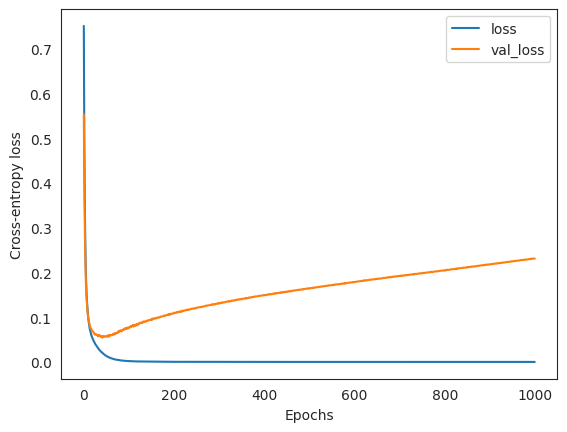

In [138]:
pd.DataFrame(model.history.history).plot(xlabel="Epochs", ylabel="Cross-entropy loss")

In [140]:
from keras.callbacks import EarlyStopping

early_stopper =  EarlyStopping(monitor="val_loss", mode="min", patience=15)

model = keras.Sequential([layers.InputLayer((X.shape[1],), name="Input"),
                          layers.Dense(30, name="Layer_1", activation="relu"),
                          layers.Dense(30, name="Layer_2", activation="relu"),
                          layers.Dense(1, name="output", activation="sigmoid")],
                         name="Classifier")
model.compile(loss= "binary_crossentropy", optimizer="adam")

model.fit(scaled_X_train_val, y_train_val, epochs=1000,
          validation_data=[scaled_X_val, y_val], callbacks=[early_stopper], verbose=1)


Epoch 1/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.8976 - val_loss: 0.6255
Epoch 2/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6387 - val_loss: 0.4659
Epoch 3/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4597 - val_loss: 0.3535
Epoch 4/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3381 - val_loss: 0.2766
Epoch 5/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2585 - val_loss: 0.2205
Epoch 6/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2102 - val_loss: 0.1796
Epoch 7/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1712 - val_loss: 0.1499
Epoch 8/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1517 - val_loss: 0.1275
Epoch 9/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1211 - val_loss: 0.1131
Epoch 10/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1381 - val_loss: 0.1035
Epoch 11/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0911 - val_loss: 0.0970
Epoch 12/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

<Axes: xlabel='Epochs', ylabel='Crossentropy loss'>

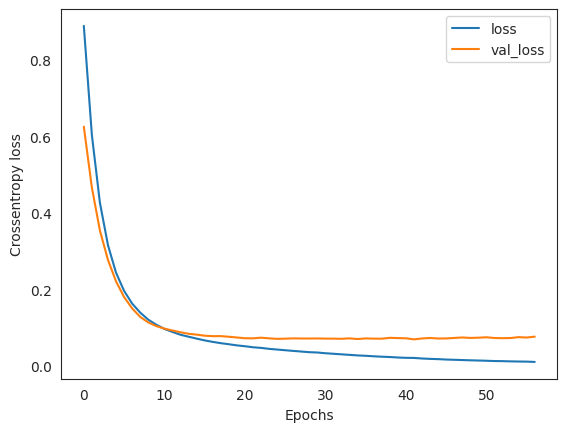

In [141]:
df_loss = pd.DataFrame(model.history.history)
df_loss.plot(xlabel="Epochs", ylabel="Crossentropy loss")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
[[9.3800253e-01]
 [4.0635033e-04]
 [1.2719281e-02]
 [9.9848533e-01]]
              precision    recall  f1-score   support

           0       1.00      0.94      0.97        32
           1       0.96      1.00      0.98        54

    accuracy                           0.98        86
   macro avg       0.98      0.97      0.97        86
weighted avg       0.98      0.98      0.98        86



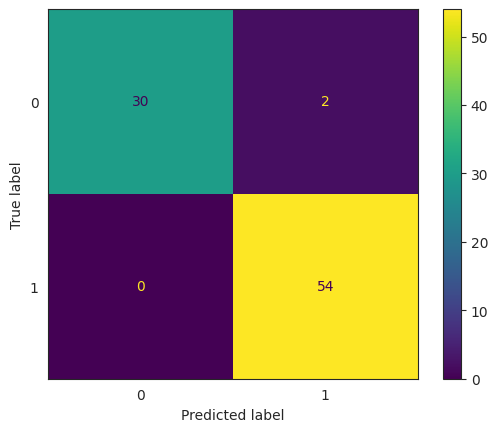

In [144]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

model = keras.Sequential([layers.InputLayer((X.shape[1],), name="Input"),
                          layers.Dense(30, name="Layer_1", activation="relu"),
                          layers.Dense(30, name="Layer_2", activation="relu"),
                          layers.Dense(1, name="output", activation="sigmoid")],
                         name="Classifier")
model.compile(loss="binary_crossentropy", optimizer="adam")

# scaled_X_train.shape, y_train.shape
model.fit(scaled_X_train, y_train, epochs=len(df_loss), validation_data=[scaled_X_test, y_test],
          callbacks=[early_stopper], verbose=0)

final_loss = pd.DataFrame(model.history.history)

y_pred = model.predict(scaled_X_test)
print(y_pred[:4])

y_pred = np.round(y_pred)

cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()
print(classification_report(y_test, y_pred))